**Summary:**

This notebook takes the output from many model runs, combines the outputs, and then analyzes the "best" runs.

**Background:**

The primary goal of this analysis is to classify successful gait training for individual subjects given (1) subject demographics, (2) gait training protocol details, and (3) baseline movement features.

To solve this classification problem I am performing a thorough, but computationally costly, search of the possible features (demographics, protocol details, and baseline movement features), model parameters, splits of the data, balancing of the data, and transforming and scaling of selected features (https://github.com/rayidghani/magicloops). **The University of Pittsburgh Center for Research Computing (CRC) H2P server was utilized.** Currently 4 models are being used: logistic regression, decision trees, random forests, and extra tree classifiers. These initial models were selected for their interpretability.  However, I would like to run 4 additional models that have performed well on preliminary runs with the current data. Currently only 1 of 3 metrics used to characterize gait training have been modeled.

**The main sections of this notebook are as follows:**
- **Combining All Models**: This section utilizes the glob library to combine all the current results from the server.
- **Analyzing All Models**: Some summary statistics of the all the models are presented in this section.
- **Defining the Best Models**: Here is where I define my critera for identifying the "best" models.
- **Analyzing Only the Best Models**: Here I do analysis to determine which models, features, parameters, and methods resulted in the best models.


# Combining All Models
https://www.freecodecamp.org/news/how-to-combine-multiple-csv-files-with-8-lines-of-code-265183e0854/

In [1]:
import os
import glob
import pandas as pd
import seaborn as sns # Also to visualize
import matplotlib.pyplot as plt  # To visualize

In [2]:
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

In [12]:
if "BestMdls.csv" in all_filenames:
    all_filenames.remove("BestMdls.csv")

if "combined_csv.csv" in all_filenames:
    all_filenames.remove("combined_csv.csv")

In [13]:
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')

In [14]:
combined_csv.shape

(7247500, 18)

# Analyzing All Models


In [24]:
import pandas as pd
combined_csv = pd.read_csv("combined_csv.csv")

In [18]:
combined_csv.head()

,Baseline,Classifier,Features,Parameters,Precision_10%,Precision_20%,Precision_30%,Precision_40%,Precision_5%,Precision_50%,ROC,Recall_10%,Recall_20%,Recall_30%,Recall_40%,Recall_5%,Recall_50%,Split Type
0,1.0,['DT'],"['C(Stroke)[T.1]', 'C(SpeedRatio)[T.3.0]', 'Sp...","DecisionTreeClassifier(max_depth=1, max_featur...",1.0,0.954545,0.939394,0.954545,1.0,0.928571,0.500000,0.123596,0.235955,0.348315,0.47191,0.05618,0.584270,KFold
1,1.0,['DT'],"['C(Stroke)[T.1]', 'C(SpeedRatio)[T.3.0]', 'Sp...","DecisionTreeClassifier(max_depth=1, max_featur...",1.0,0.954545,0.969697,0.954545,1.0,0.946429,0.565217,0.123596,0.235955,0.359551,0.47191,0.05618,0.595506,KFold
2,1.0,['DT'],"['C(Stroke)[T.1]', 'C(SpeedRatio)[T.3.0]', 'Sp...","DecisionTreeClassifier(max_depth=1, max_featur...",1.0,0.954545,0.939394,0.954545,1.0,0.928571,0.500000,0.123596,0.235955,0.348315,0.47191,0.05618,0.584270,KFold
3,1.0,['DT'],"['C(Stroke)[T.1]', 'C(SpeedRatio)[T.3.0]', 'Sp...","DecisionTreeClassifier(max_depth=1, max_featur...",1.0,0.954545,0.939394,0.954545,1.0,0.928571,0.500000,0.123596,0.235955,0.348315,0.47191,0.05618,0.584270,KFold
4,1.0,['DT'],"['C(Stroke)[T.1]', 'C(SpeedRatio)[T.3.0]', 'Sp...","DecisionTreeClassifier(max_depth=1, max_featur...",1.0,0.954545,0.939394,0.954545,1.0,0.928571,0.500000,0.123596,0.235955,0.348315,0.47191,0.05618,0.584270,KFold


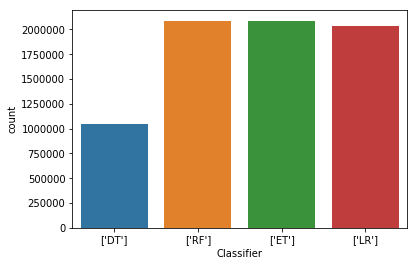

In [19]:
sns.countplot(x="Classifier", data=combined_csv)
plt.show()

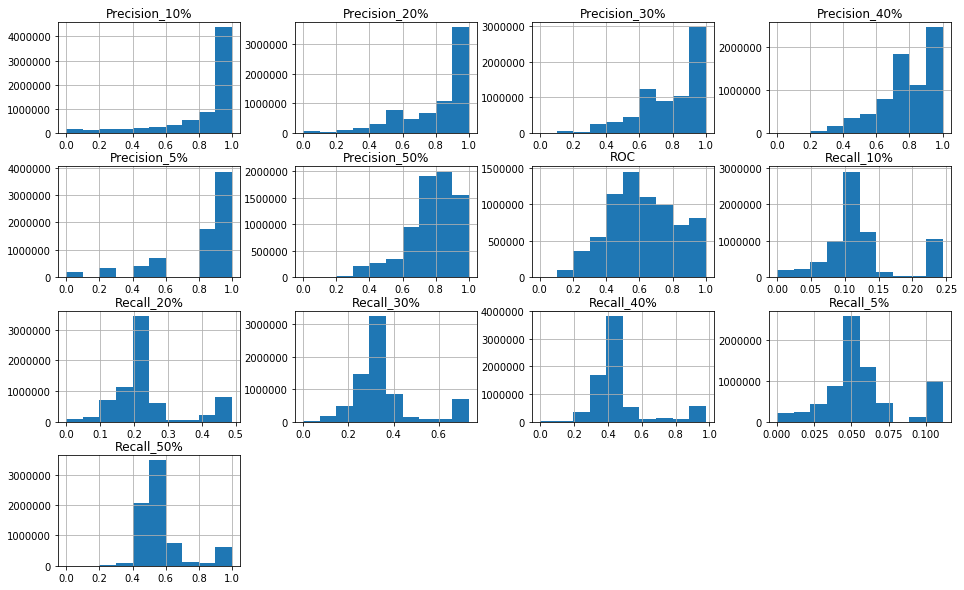

In [36]:
combined_csv[['ROC', 'Recall_5%', 'Recall_10%', 'Recall_20%', 'Recall_30%', 'Recall_40%', 'Recall_50%',\
              'Precision_5%', 'Precision_10%', 'Precision_20%', 'Precision_30%', 'Precision_40%', 'Precision_50%']].hist(figsize = (16, 10));
plt.show()

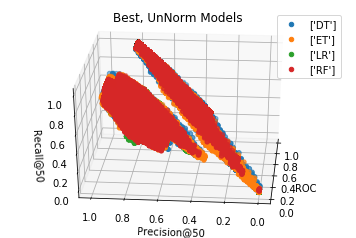

In [22]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

groups = combined_csv.groupby("Classifier")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for name, group in groups:
    #plt.plot(group["ROC"], group["Precision_50%"], marker="o", linestyle="", label=name)
    ax.scatter(group["ROC"], group["Precision_50%"], group["Recall_50%"], marker="o", label=name)

ax.view_init(30, 185)
ax.set_xlabel('ROC')
ax.set_ylabel('Precision@50')
ax.set_zlabel('Recall@50')
ax.set_title("Best, UnNorm Models")
plt.legend()
plt.show()

# Defining the Best Models

In [46]:
IndexNotOfInterest = (combined_csv["ROC"]<.95)  | \
    (combined_csv["Precision_50%"]<.81) | (combined_csv["Recall_50%"]<.95) 

BestMdls = combined_csv.drop(combined_csv[IndexNotOfInterest].index)
BestMdls.shape

(305877, 18)

In [47]:
BestMdls.to_csv( "BestMdls.csv", index=False, encoding='utf-8-sig')

# Analyzing Only the Best Models

In [48]:
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns # Also to visualize

BestMdls = pd.read_csv("BestMdls.csv")
BestMdls.head()

,Baseline,Classifier,Features,Parameters,Precision_10%,Precision_20%,Precision_30%,Precision_40%,Precision_5%,Precision_50%,ROC,Recall_10%,Recall_20%,Recall_30%,Recall_40%,Recall_5%,Recall_50%,Split Type
0,1.0,['DT'],"['C(Stroke)[T.1]', 'C(SpeedRatio)[T.3.0]', 'Sp...","DecisionTreeClassifier(max_depth=5, max_featur...",1.0,1.0,0.969697,0.977273,1.0,0.818182,0.995623,0.244444,0.488889,0.711111,0.955556,0.111111,1.0,KFold
1,1.0,['DT'],"['C(Stroke)[T.1]', 'C(SpeedRatio)[T.3.0]', 'Sp...","DecisionTreeClassifier(max_depth=5, max_featur...",1.0,1.0,0.969697,0.977273,1.0,0.818182,0.995623,0.244444,0.488889,0.711111,0.955556,0.111111,1.0,KFold
2,1.0,['DT'],"['C(Stroke)[T.1]', 'C(SpeedRatio)[T.3.0]', 'Sp...","DecisionTreeClassifier(max_depth=5, max_featur...",1.0,1.0,0.969697,0.977273,1.0,0.818182,0.995623,0.244444,0.488889,0.711111,0.955556,0.111111,1.0,KFold
3,1.0,['DT'],"['C(Stroke)[T.1]', 'C(SpeedRatio)[T.3.0]', 'Sp...","DecisionTreeClassifier(max_depth=5, max_featur...",1.0,1.0,0.969697,0.977273,1.0,0.818182,0.995623,0.244444,0.488889,0.711111,0.955556,0.111111,1.0,KFold
4,1.0,['DT'],"['C(Stroke)[T.1]', 'C(SpeedRatio)[T.3.0]', 'Sp...","DecisionTreeClassifier(max_depth=5, max_featur...",1.0,1.0,0.969697,0.977273,1.0,0.818182,0.995623,0.244444,0.488889,0.711111,0.955556,0.111111,1.0,KFold


In [52]:
BestMdls.shape

(305877, 18)

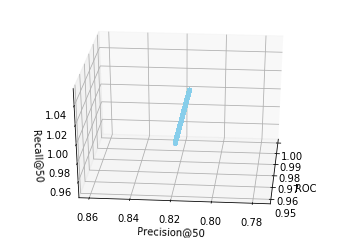

In [53]:
# plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(BestMdls["ROC"], BestMdls["Precision_50%"], BestMdls["Recall_50%"], c='skyblue', s=10)
ax.view_init(30, 185)
ax.set_xlabel('ROC')
ax.set_ylabel('Precision@50')
ax.set_zlabel('Recall@50')
plt.show()

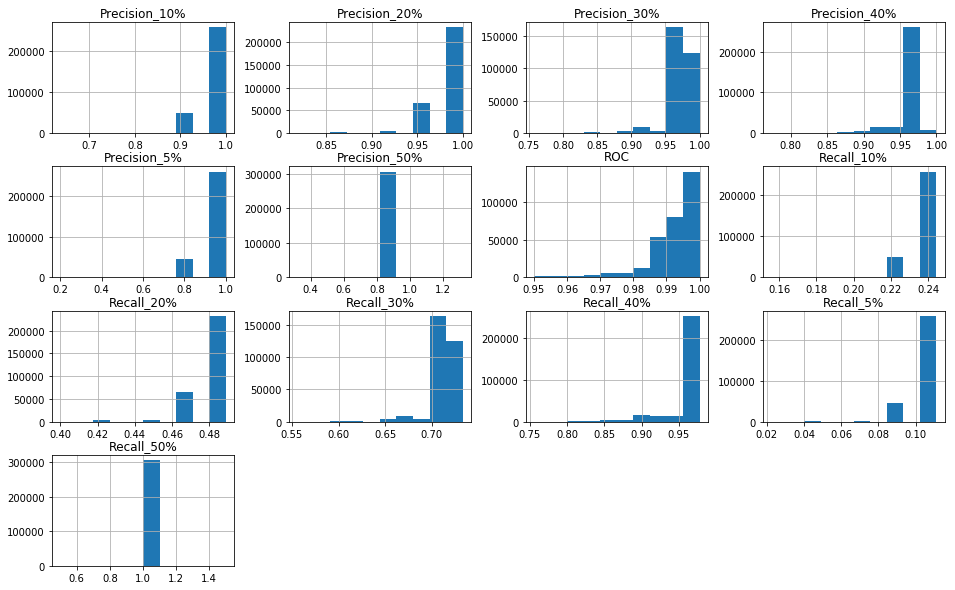

In [54]:
BestMdls[['ROC', 'Recall_5%', 'Recall_10%', 'Recall_20%', 'Recall_30%', 'Recall_40%', 'Recall_50%',\
              'Precision_5%', 'Precision_10%', 'Precision_20%', 'Precision_30%', 'Precision_40%', \
          'Precision_50%']].hist(figsize = (16, 10));
plt.show()

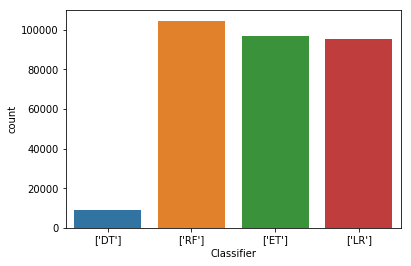

In [55]:
sns.countplot(x="Classifier", data=BestMdls)
plt.show()

In [58]:
DT_index = BestMdls[BestMdls['Classifier'] == "['DT']"].index.values
ET_index = BestMdls[BestMdls['Classifier'] == "['ET']"].index.values
RF_index = BestMdls[BestMdls['Classifier'] == "['RF']"].index.values
LR_index = BestMdls[BestMdls['Classifier'] == "['LR']"].index.values

<function matplotlib.pyplot.show(*args, **kw)>

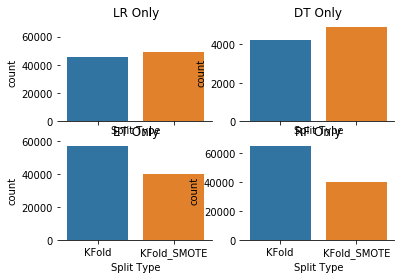

In [61]:
# Set up the matplotlib figure to show how SMOTING the data is beneficial for each model
f, axes = plt.subplots(2, 2, sharex=True)
sns.despine(left=True)

sns.countplot(x="Split Type", data=BestMdls.iloc[LR_index], ax=axes[0, 0])
axes[0, 0].set_title("LR Only")
axes[0, 0].set_ylim(0, 70000)

sns.countplot(x="Split Type", data=BestMdls.iloc[DT_index], ax=axes[0, 1])
axes[0, 1].set_title("DT Only")
axes[0, 0].set_ylim(0, 70000)

sns.countplot(x="Split Type", data=BestMdls.iloc[ET_index], ax=axes[1, 0])
axes[1, 0].set_title("ET Only")
axes[0, 0].set_ylim(0, 70000)

sns.countplot(x="Split Type", data=BestMdls.iloc[RF_index], ax=axes[1, 1])
axes[1, 1].set_title("RF Only")
axes[0, 0].set_ylim(0, 70000)

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

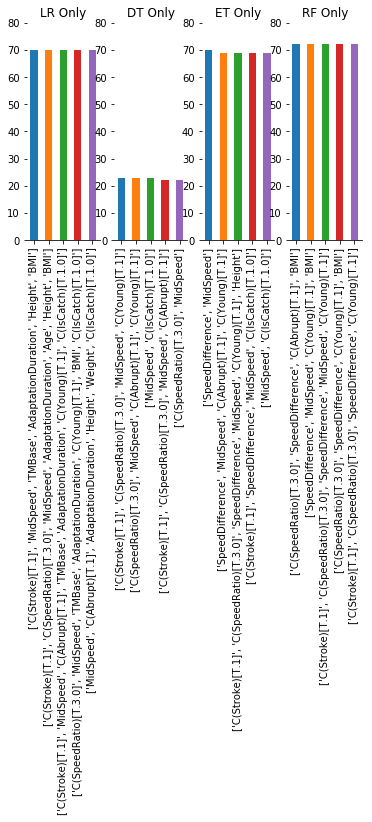

In [66]:
# Set up the matplotlib figure to show how the features vary across models
f, axes = plt.subplots(1, 4, sharex=False)
sns.despine(left=True)

f1 = pd.Series(BestMdls["Features"].iloc[LR_index])
f1.value_counts()[:5].plot(kind="bar", ax=axes[0])
axes[0].set_title("LR Only")
axes[0].set_ylim(0, 80)

f2 = pd.Series(BestMdls["Features"].iloc[DT_index])
f2.value_counts()[:5].plot(kind="bar", ax=axes[1])
axes[1].set_title("DT Only")
axes[1].set_ylim(0, 80)

f3 = pd.Series(BestMdls["Features"].iloc[ET_index])
f3.value_counts()[:5].plot(kind="bar", ax=axes[2])
axes[2].set_title("ET Only")
axes[2].set_ylim(0, 80)

f4 = pd.Series(BestMdls["Features"].iloc[RF_index])
f4.value_counts()[:5].plot(kind="bar", ax=axes[3])
axes[3].set_title("RF Only")
axes[3].set_ylim(0, 80)

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

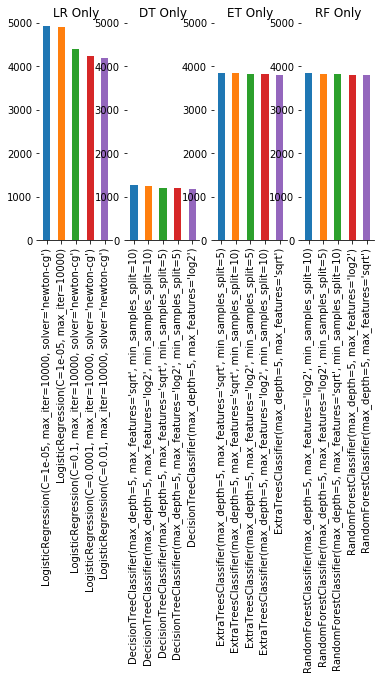

In [70]:
# Set up the matplotlib figure to show how the paremeter vary across models
f, axes = plt.subplots(1, 4, sharex=False)
sns.despine(left=True)

f1 = pd.Series(BestMdls["Parameters"].iloc[LR_index])
f1.value_counts()[:5].plot(kind="bar", ax=axes[0])
axes[0].set_title("LR Only")
axes[0].set_ylim(0, 5000)

f2 = pd.Series(BestMdls["Parameters"].iloc[DT_index])
f2.value_counts()[:5].plot(kind="bar", ax=axes[1])
axes[1].set_title("DT Only")
axes[1].set_ylim(0, 5000)

f3 = pd.Series(BestMdls["Parameters"].iloc[ET_index])
f3.value_counts()[:5].plot(kind="bar", ax=axes[2])
axes[2].set_title("ET Only")
axes[2].set_ylim(0, 5000)

f4 = pd.Series(BestMdls["Parameters"].iloc[RF_index])
f4.value_counts()[:5].plot(kind="bar", ax=axes[3])
axes[3].set_title("RF Only")
axes[3].set_ylim(0, 5000)

plt.show